In [1]:
# make the fortran module using f2py if you haven't already
# f2py -c -m bottCC coad1dpy.f 

import bottCC as bcc # import the collision coalescence module
# set parameters 
# rq0 is the radius mode in microns
# xmw is the total water content in g/m3
# nbins is the number of bins (this is hard coded in the fortran code to be 400)
# dt is the time step in seconds 
rq0_in=10.
xmw_in=1.0
nbins=400
dt=1.0
g_out,r_out,dlnr_out = bcc.coad1d_init(rq0_in,xmw_in,nbins,dt)  # this initializes the arrays and sets the initial mass distribution
# r_out is the range of radii in microns
# g_out is the initial mass distribution in g/m3/ln(r) 
# g_out.sum()*dlnr_out is the total water content
# while subroutine coad1d_init analytically sets the initial mass distribution, 
# one can set the initial mass distribution to any distribution they want and 
# reset the initial mass distribution using subroutine set_g_initial
t=0.0
g_out=2*g_out
bcc.set_g_initial(g_out) # this resets the initial mass distribution to 2 times the initial mass distribution

while t<3600:
    g,t = bcc.integrate(nbins,dt,t)


(1e-11, 0.01)

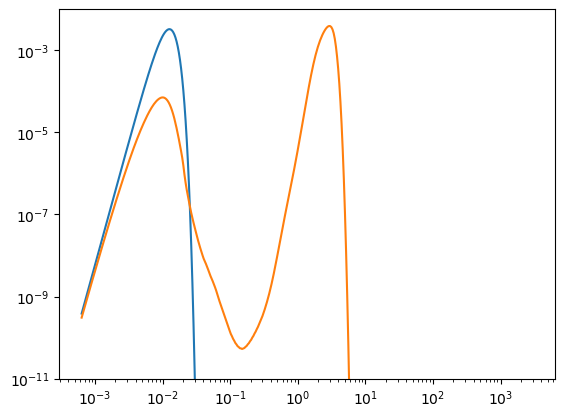

In [3]:

import matplotlib.pyplot as plt

plt.plot(r_out[:400]*1e-3,g_out[:400])
plt.xscale('log')
plt.yscale('log')

plt.plot(r_out[:400]*1e-3,g[:400])
plt.ylim(1e-11,1e-2) 


In [51]:
#from nGammaDSD import *
import nGammaDSD as nG  # import the normalized gamma dsd module
import importlib
importlib.reload(nG)

nw=0.08
lwc=np.arange(40)*0.1+0.05
mu=2.0
f_mu=nG.fmu(mu)
dm0=10*nG.dm_lwc(nw,lwc[0],1000)
lwc1,mD,dInt=nG.getMassDist(nw,dm0,f_mu,mu,1000) # get the mass distribution for a given lwc, nw and mu

In [52]:
from scipy.ndimage import gaussian_filter1d
g_int=g_out.copy()*0.0 
# bin the mass distribution to the same bins as the collision coalescence code
for md1,d1 in zip(mD,dInt):
    ibin=np.log(d1/2*1e3)/dlnr_out
    g_int[int(ibin)]+=md1/dlnr_out*1e-3

g_int1=gaussian_filter1d(g_int,2.0) # smooth the mass distribution to remove binning artifacts
print(g_int.sum()*dlnr_out,lwc1,g_int1.sum()*dlnr_out)


5.000000267610383e-05 0.05000000001301696 4.9999993710220236e-05


In [53]:

t=0.0 # reset time to 0.0
bcc.set_g_initial(g_int1) # this resets the initial mass distribution to g_int

while t<3600:
    g,t = bcc.integrate(nbins,dt,t)


0.049999993710220236 0.049999993710220236


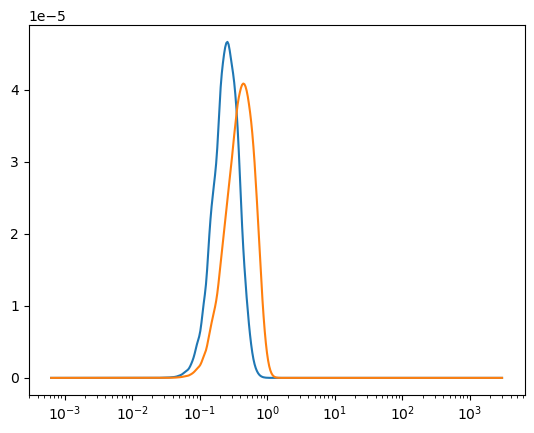

In [54]:

plt.plot(r_out[:400]*1e-3,g_int1[:400])
plt.plot(r_out[:400]*1e-3,g[:400])

plt.xscale('log')
#plt.yscale('log')

print(g.sum()*dlnr_out*1e3,g_int1.sum()*dlnr_out*1e3)

In [64]:
# everything together
nw=0.08*10**(np.random.randn()*2) # randomly choose a nw [cm-4]
lwci=0.01+np.random.rand()*3      # randomly choose a lwc [g/m3]
mu=np.random.rand()*4             # set mu
f_mu=nG.fmu(mu)
dm0=10*nG.dm_lwc(nw,lwci,1000)    # calculate dm0 in cm
g_int=g_out.copy()*0.0
lwc1,mD,dInt=nG.getMassDist(nw,dm0,f_mu,mu,1000) # get the mass distribution for a given lwc, nw and mu
for md1,d1 in zip(mD,dInt):
    ibin=np.log(d1/2*1e3)/dlnr_out
    g_int[int(ibin)]+=md1/dlnr_out*1e-3

g_int1=gaussian_filter1d(g_int,2.0)
print(g_int.sum()*dlnr_out,lwc1,g_int1.sum()*dlnr_out)
print(lwc1,lwci)

6.018852346606485e-05 0.06018852608259138 6.018852794900664e-05
0.06018852608259138 0.060188557633824906
